### Extract the Text From the Image Overlay of a PhenoCam Image

Try to create a stand alone script that takes a image as input and extracts the text from an image overlay.  In particular we're interested in extracting the image exposure value.  I'm using the `pyphenocam` package by Colin Talbert on [GitHub](https://github.com/ColinTalbert/pyphenocam) as a starting point.

In [1]:
import pickle as _pickle
from pkg_resources import resource_filename as _resource_filename

import numpy as _np
import matplotlib as mpl
from matplotlib import pyplot as plt

import skimage as _skimage
from skimage.color.adapt_rgb import adapt_rgb as _adapt_rgb
import skimage.io as _skimageio
from skimage.measure import label as _label
from skimage import filters as _filters

In [2]:
def _get_lines(fname):
    """
    Returns the portions of the image cooresponding to the
    first four lines of text in the header.
    These are returned as 3D numpy arrays.
    """
    @_adapt_rgb(_skimage.color.adapt_rgb.hsv_value)
    def sobel_hsv(image):
        return _filters.sobel(image)

    # read in image file
    data = _skimageio.imread(fname)

    # select default ranges for the first 4 lines (this may vary from site to site)
    # possibly make these input parameters
    l1_range = data[0:27, 0:850, :]
    l2_range = data[28:55, 0:500, :]
    l3_range = data[56:83, 0:350, :]
    l4_range = data[84:111, 0:350, :]

    # Look for a right edge in the image in the default ranges which
    # would indicate an end of the overlay in the x direction
    l1_edges = _np.sum(
        _skimage.exposure.rescale_intensity(1 - sobel_hsv(l1_range)), axis=2) < 2
    l2_edges = _np.sum(
        _skimage.exposure.rescale_intensity(1 - sobel_hsv(l2_range)), axis=2) < 2
    l3_edges = _np.sum(
        _skimage.exposure.rescale_intensity(1 - sobel_hsv(l3_range)), axis=2) < 2
    l4_edges = _np.sum(
        _skimage.exposure.rescale_intensity(1 - sobel_hsv(l4_range)), axis=2) < 2

    # try to adjust the default ranges if an edge was found
    try:
        l1_right_edge = 0 + \
            _np.where(_np.sum(l1_edges, axis=0) >= 25)[0].max()
    except ValueError:
        l1_right_edge = 850
    if l1_right_edge < 2:
        l1_right_edge = 850

    try:
        l2_right_edge = 0 + \
            _np.where(_np.sum(l2_edges, axis=0) >= 25)[0].max()
    except ValueError:
        l2_right_edge = 500
    if l2_right_edge < 2:
        l2_right_edge = 500

    try:
        l3_right_edge = 0 + \
            _np.where(_np.sum(l3_edges, axis=0) >= 25)[0].max()
    except ValueError:
        l3_right_edge = 350
    if l3_right_edge < 2:
        l3_right_edge = 350

    try:
        l4_right_edge = 0 + \
            _np.where(_np.sum(l4_edges, axis=0) >= 25)[0].max()
    except ValueError:
        l4_right_edge = 350
    if l4_right_edge < 2:
        l4_right_edge = 350

    # extract an array for each of the first four lines
    line1 = data[0:27, :l1_right_edge, :]
    line2 = data[28:55, :l2_right_edge, :]
    line3 = data[56:83, :l3_right_edge, :]
    line4 = data[84:111, :l4_right_edge, :]
    
    return line1, line2, line3, line4


In [3]:
infile = "quickbird_2014_05_23_130005.jpg"
lines = _get_lines(infile)

27 774 3


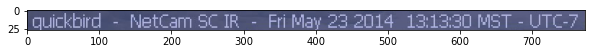

In [4]:
xsize, ysize, zsize = lines[0].shape
print(xsize, ysize, zsize)
plt.figure(figsize=(10,4))
plt.imshow(lines[0])

27 306 3


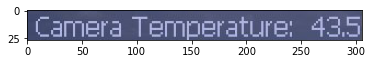

In [5]:
xsize, ysize, zsize = lines[1].shape
print(xsize, ysize, zsize)
plt.imshow(lines[1])

27 156 3


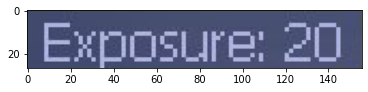

In [6]:
xsize, ysize, zsize = lines[2].shape
print(xsize, ysize, zsize)
plt.imshow(lines[2])

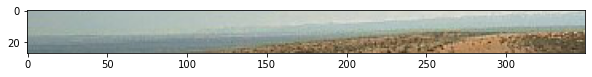

In [7]:
# for quickbird there was no fourth line
plt.figure(figsize=(10,4))
plt.imshow(lines[3])

In [8]:
# load a dictionary with the binary pattern for each numeric digit
_digits_fname = _resource_filename(__name__, './data/DIGITDICT.p')
print
DIGITDICT = _pickle.load(open(_digits_fname, "rb"), encoding='bytes')

# load a dictionary with the binary pattern for each character
_digits_full_fname = _resource_filename(__name__, 'data/DIGITDICT_FULL.p')
DIGITDICT_FULL = _pickle.load(open(_digits_full_fname, "rb"),
                              encoding='latin1')

In [9]:
# print the full dictionary keys
keys = list(DIGITDICT_FULL.keys())
print("Number of keys: {}".format(len(keys)))
keys.sort()
print(keys)

Number of keys: 56
['%', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', 'A', 'C', 'E', 'F', 'H', 'I', 'J', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'W', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '°']


Hmmmm ... some uppercase letters are missing.

In [10]:
keys = list(DIGITDICT.keys())
print(keys)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '.']


Hmmmm ... not sure why the numbers are not character strings.  I guess this might make sense, but it might be better to assemble a complete string then convert to a numeric value.

In [11]:
# just for fun convert to characters
newdict = {}
for key in DIGITDICT:
    value = DIGITDICT[key]
    newdict[str(key)] = value
    
keys = list(newdict.keys())
print(keys)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.']


In [12]:
def get_header_contents(fname):
    """
    """
    line1, line2, line3, line4 = _get_lines(fname)

    output = {}
    for line in [('line1', line1),
                 ('line2', line2),
                 ('line3', line3),
                 ('line4', line4), ]:
        if len(_np.unique(line[1])) > 1:
            line_binary = _get_binary(line[1])
            output[line[0]] = _extract_digits(line_binary)
        else:
            output[line[0]] = ''

    return output

In [13]:
def _get_binary(raw_data):
    """
    Given an image array returns the image converted to a
    "cleaned up" binary (i.e. only values of 1 or 0) array.
    The returned array is actually a boolean array!
    """
    #try:
    #    gray_data = _skimage.color.rgb2gray(raw_data)
    #except:
    #    gray_data = raw_data

    try:
        thresh = _skimage.filters.threshold_otsu(raw_data[:, :, 2])
        binary = raw_data[:, :, 2] > thresh
        #binary = binary[:, :, 0]
    except ValueError:
        print('valueerror')
        binary = _np.ones(raw_data.shape).astype('bool')

    return binary

In [14]:
def _segment(binary):
    """
    Parses a chunk of text provided in a boolean numpy array.
    Returns:
        a tuple with a list of unique tags for each each individual 'letter'
        a numpy array with these tags inserted where the 'letters' are.
        
    The skimage.measure.label() function segments an array into "connected" parts,
    the idea being the each character in the images is a group of connected pixels.
    I'm not sure how characters which are not all connected (e.g. "i", ":") are 
    handled.  The code below connects these "unconnected" chars by looking at the
    transpose array!
    """
    label_image = _label(binary)

    digit_labels = []
    for column in label_image.T:
        col_vals = _np.unique(column)
        if len(col_vals) == 1:
            pass
        elif len(col_vals) == 2 and col_vals[1] not in digit_labels:
            digit_labels.append(col_vals[1])
        elif len(col_vals) == 3:
            label_image[label_image == col_vals[2]] = col_vals[1]
            if col_vals[1] not in digit_labels:
                digit_labels.append(col_vals[1])

    return digit_labels, label_image

In [15]:
line_bin = _get_binary(lines[2])
digit_labels, label_image = _segment(line_bin)
print(digit_labels)

[1, 4, 5, 6, 7, 8, 9, 10, 11, 2, 3]


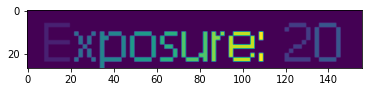

In [16]:
plt.imshow(label_image)

[ 0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  4  4  0  0  4  4  0  0  0  0  5  5  5  5  0  0  0  0  0  0  5  5  0  0
  6  6  0  0  0  0  0  0  0  0  6  6  0  0  7  7  0  0  0  0  0  0  0  0
  8  8  0  0  0  0  0  0  0  0  8  8  0  0  9  9  9  9  0  0  0  0 10 10
  0  0  0  0  0  0  0  0 10 10  0  0 11 11  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  2  2  0  0  3  3  0  0  0  0  0  0  0  0
  3  3  0  0  0  0  0  0  0  0  0  0]
(27, 156)


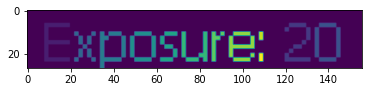

In [17]:
# look at what label returns for our "binary array"
label_image = _label(line_bin)
print(label_image[13])
print(label_image.shape)
plt.imshow(label_image)

This sort of makes sense.  The processing starts in the upper left-hand corner and goes from left to right for each line.  The first 1/true pixel is in the "E" character. The next is in the "2" character, then the "0" , then the "x".  The two unconnected parts of ":" have different colors.
So other than the colon every character is given a different numeric label.

In [18]:
def _get_digit(binary, label_image, digit):
    """
    Extracts a 'character' from a labeled image corresponding to the
    specified tag.  returns a binary numpy array with just that
    character's pixels.
    """
    ymin, ymax = _np.where(label_image == digit)[0].min(), \
        _np.where(label_image == digit)[0].max() + 1
    xmin, xmax = _np.where(label_image == digit)[1].min(), \
        _np.where(label_image == digit)[1].max() + 1

    return binary[ymin:ymax, xmin:xmax]

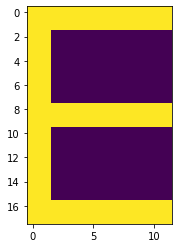

In [19]:
first_char_image = _get_digit(line_bin, label_image, 1)
plt.imshow(first_char_image)

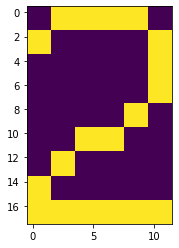

In [20]:
second_char_image = _get_digit(line_bin, label_image, 2)
plt.imshow(second_char_image)

In [21]:
def _return_num(num_image):
    """
    Given a binary array of a single digit returns the digit (string
    character) of the matching image in our DIGITDICT

    """
    for digit, digit_image in DIGITDICT.items():
        if _np.array_equal(digit_image, num_image):
            return digit

    return -1

In [22]:
value = _return_num(second_char_image)
print(value)

2


In [23]:
def _return_char(num_image):
    """
    Given a binary array of a single digit returns the digit (string
    character) of the matching image in our DIGITDICT
    """
    for digit, digit_image in DIGITDICT_FULL.items():
        if _np.array_equal(digit_image, num_image):
            return digit

    return ' '

In [24]:
result = _return_char(first_char_image)
print(type(result))
print(_return_char(first_char_image))

<class 'str'>
E


In [25]:
def _extract_digits(binary):
    """
    Given a binary chunk (A single line) of text
    Returns the numeric digits it contains.

    Ignores letters and noise. (NOT really!)
    """
    digit_labels, labeled_image = _segment(binary)

    ans = ""
    for digit_label in digit_labels:
        try:
            digit = _get_digit(binary, labeled_image, digit_label)
            num = _return_char(digit)
        except ValueError:
            # print("ValueError raised")
            continue
        
        if num is not None:
            ans += num
           
    return ans

In [26]:
digits = _extract_digits(_get_binary(lines[2]))
print(type(digits))
print(digits)

<class 'str'>
Exposure:20


Okay, the way I understand it this the function is not working as intended.  The term "digit" is really better described as a "chunk" of the image which represents a character.  So `_extract_digits()` just returns a character string of all the characters in the line. It doesn't seem to ignore characters or noise as it says in the comments.

In [27]:
# test get header contents
header = get_header_contents(infile)
print(header)

{'line1': 'quickbird-NetCamSCIR-FriMay23201413:13:30MST-UTC-7', 'line2': 'CameraTemperature:43.5', 'line3': 'Exposure:20', 'line4': ' '}


In [28]:
def get_exposure(fname):

    header_contents = get_header_contents(fname)

    # 4 line header, readingma style
    if "Exposure:" in header_contents['line4']:
        exposure_line = header_contents['line4']
        return exposure_line[exposure_line.index(':') + 1:]
    elif "Exposure:" in header_contents['line3']:  # quickbird style
        exposure_line = header_contents['line3']
        return exposure_line[exposure_line.index(':') + 1:]
    elif "Exposure:" in header_contents['line1']:  # harvard style
        exposure_line = header_contents['line1']
        return exposure_line[exposure_line.index('Exposure:') + 9:]
    else:
        return "didn't work"

In [29]:
# test get_exposure()
exposure = get_exposure(infile)
print(type(exposure))
print("Exposure: {}".format(exposure))

<class 'str'>
Exposure: 20


In [30]:
get_header_contents(infile)

{'line1': 'quickbird-NetCamSCIR-FriMay23201413:13:30MST-UTC-7',
 'line2': 'CameraTemperature:43.5',
 'line3': 'Exposure:20',
 'line4': ' '}

In [31]:
def get_temperature(fname):
    """
    Given a filename of a phenocam image
    Returns the camera temperature from the image.
    """
    header_contents = get_header_contents(fname)

    # check each line in the header starting from the bottom
    if "Temperature:" in header_contents['line4']:
        temperature_line = header_contents['line4']
        return temperature_line[temperature_line.index(':') + 1:]
    elif "Temperature:" in header_contents['line3']:  # quickbird style
        temperature_line = header_contents['line3']
        return temperature_line[temperature_line.index(':') + 1:]
    elif "Temperature:" in header_contents['line2']:  # quickbird style
        temperature_line = header_contents['line2']
        return temperature_line[temperature_line.index(':') + 1:]
    elif "Temperature:" in header_contents['line1']:  # harvard style
        temperature_line = header_contents['line1']
        return temperature_line[temperature_line.index(':') + 1:]
    else:
        if verbose:
            sys.stderr.write("didn't work\n")
        return None



In [32]:
temp = get_temperature(infile)
temp = float(temp)
print("Temperature: {}".format(temp))

Temperature: 43.5


In [33]:
get_exposure('harvard_2008_04_04_113141.jpg')

'402'

In [34]:
get_exposure('quickbird_2014_05_23_130005.jpg')

'20'

In [35]:
get_exposure('bozeman_2016_11_11_111805.jpg')

'10'

In [36]:
get_header_contents('bozeman_2016_11_11_111805.jpg')

{'line1': 'bozeman-NetCamSCIR-FriNov11201611:18:05MST-UTC-7',
 'line2': 'CameraTemperature:25.0',
 'line3': 'Exposure:10',
 'line4': '       '}